In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-06_19-01_20180401_20181231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2018-04-02 02:27:00,CL,BUY,1,65.30,1,ENTRY,2.37,0.00,"[CommissionReport(execId=1, commission=2.37, c...",100000.00
2018-04-02 13:34:00,GC,BUY,3,1337.20,3,ENTRY,7.26,0.00,"[CommissionReport(execId=2, commission=7.26, c...",100000.00
2018-04-02 13:48:00,GC,SELL,3,1336.90,4,STOP-LOSS,7.26,-104.52,"[CommissionReport(execId=3, commission=7.26, c...",99895.48
2018-04-02 14:05:00,GC,BUY,3,1338.10,5,ENTRY,7.26,0.00,"[CommissionReport(execId=4, commission=7.26, c...",99895.48
2018-04-02 14:33:00,CL,SELL,1,64.95,2,STOP-LOSS,2.37,-354.74,"[CommissionReport(execId=5, commission=2.37, c...",99540.74
...,...,...,...,...,...,...,...,...,...,...
2018-12-28 14:53:00,CL,BUY,1,45.31,2889,STOP-LOSS,2.37,-764.74,"[CommissionReport(execId=2884, commission=2.37...",164832.82
2018-12-28 20:38:00,NQ,BUY,3,6367.75,2890,ENTRY,6.30,0.00,"[CommissionReport(execId=2885, commission=6.30...",164832.82
2018-12-28 20:43:00,ES,BUY,3,2515.25,2892,ENTRY,6.30,0.00,"[CommissionReport(execId=2886, commission=6.30...",164832.82


In [4]:
df[(df['contract']=='ES')]

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2018-04-02 15:49:00,ES,SELL,3,2626.25,12,ENTRY,6.3,0.0,"[CommissionReport(execId=11, commission=6.3000...",99151.70
2018-04-02 21:20:00,ES,BUY,3,2574.50,14,STOP-LOSS,6.3,7749.9,"[CommissionReport(execId=29, commission=6.3000...",110590.52
2018-04-04 10:12:00,ES,SELL,3,2569.75,41,ENTRY,6.3,0.0,"[CommissionReport(execId=39, commission=6.3000...",110666.06
2018-04-04 15:37:00,ES,BUY,3,2582.50,43,STOP-LOSS,6.3,-1925.1,"[CommissionReport(execId=53, commission=6.3000...",107072.94
2018-04-05 17:10:00,ES,BUY,3,2666.25,77,ENTRY,6.3,0.0,"[CommissionReport(execId=77, commission=6.3000...",109705.72
...,...,...,...,...,...,...,...,...,...,...
2018-12-26 10:55:00,ES,BUY,3,2358.25,2849,STOP-LOSS,6.3,-4250.1,"[CommissionReport(execId=2846, commission=6.30...",162349.60
2018-12-27 19:49:00,ES,SELL,3,2409.00,2874,ENTRY,6.3,0.0,"[CommissionReport(execId=2867, commission=6.30...",167081.26
2018-12-27 21:11:00,ES,BUY,3,2430.75,2875,STOP-LOSS,6.3,-3275.1,"[CommissionReport(execId=2871, commission=6.30...",164544.20


In [5]:
df[(df['contract']=='ES') & (df['realizedPNL'] != 0)].count()

contract        109
action          109
amount          109
price           109
order_id        109
reason          109
commission      109
realizedPNL     109
comm_reports    109
cash            109
dtype: int64

In [6]:
df.groupby('contract').realizedPNL.sum()

contract
CL    -3975.12
ES    28139.10
GC   -32490.56
NQ    69519.20
Name: realizedPNL, dtype: float64

In [7]:
df.realizedPNL.sum()

61192.62000000001

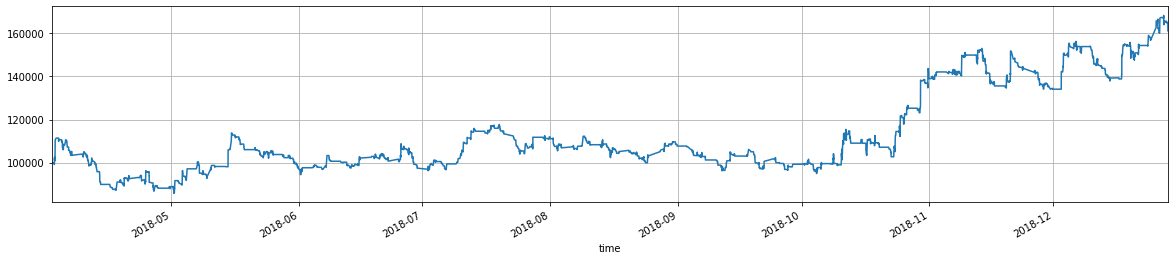

In [8]:
df.cash.plot(figsize=(20,4), grid=True);

In [9]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL     576
ES     218
GC    1012
NQ    1082
Name: action, dtype: int64

In [11]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    1365.12
ES    1373.40
GC    9360.56
NQ    6610.80
Name: commission, dtype: float64

In [12]:
df.commission.sum()

18709.88

In [13]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.36,-64.21,655.07,-475.23,1.38,-68.32,506.0
CL,0.35,-13.80,585.16,-332.40,1.76,-11.25,288.0
NQ,0.41,128.50,1344.44,-724.19,1.86,123.95,541.0
ES,0.46,258.16,2847.90,-1936.54,1.47,264.30,109.0
total,0.39,42.38,1115.36,-631.41,1.77,49.83,1444.0


In [14]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [15]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,0.086303,0.058430,0.021766,0.232167
ES,0.086303,1.000000,-0.019184,0.188080,0.701502
GC,0.058430,-0.019184,1.000000,-0.024905,0.251582
NQ,0.021766,0.188080,-0.024905,1.000000,0.669592
total,0.232167,0.701502,0.251582,0.669592,1.000000


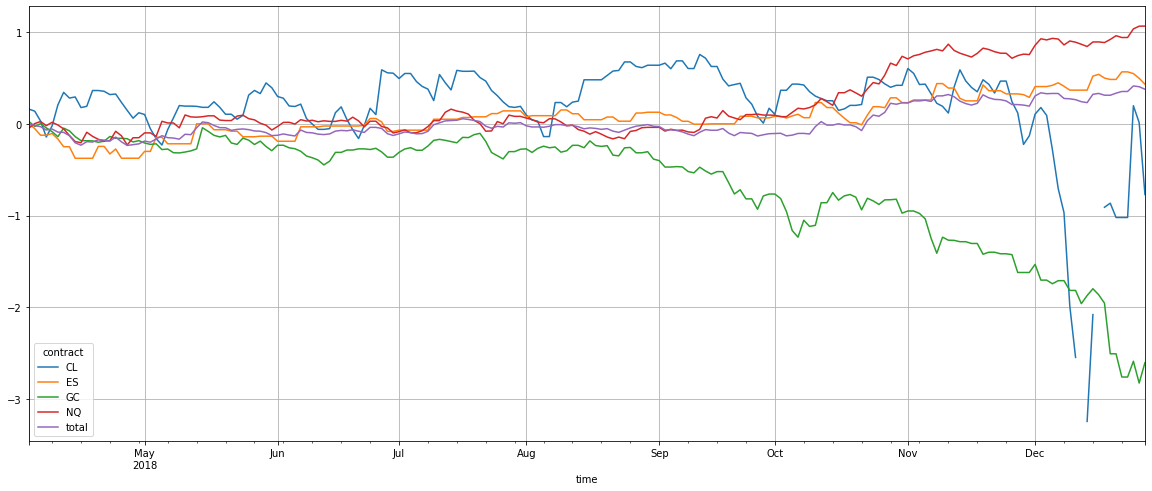

In [16]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

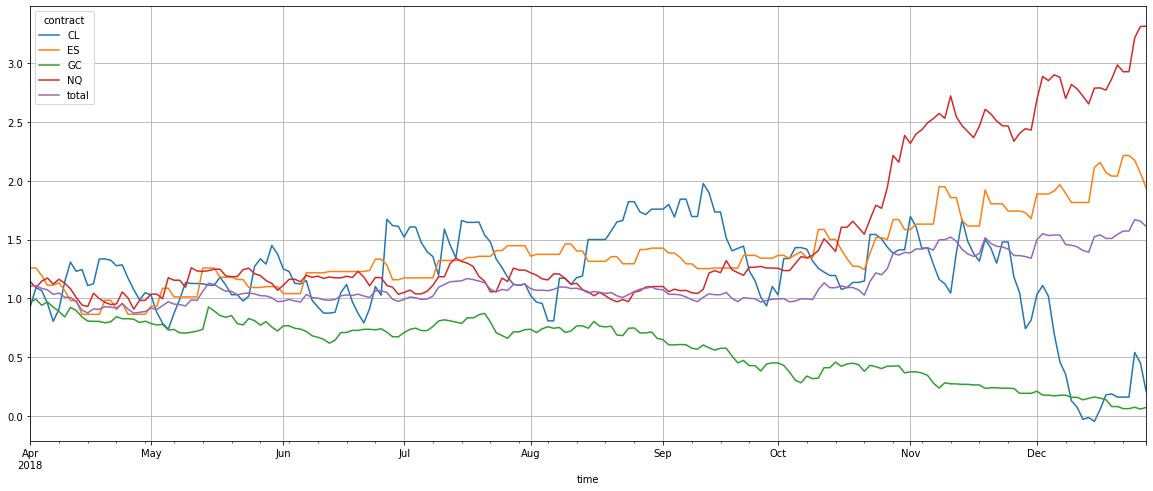

In [17]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [18]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,-0.871024,1.351477,-0.966813,3.709939,0.853334
Cumulative returns,-0.795024,0.937970,-0.928302,2.317307,0.611926
Annual volatility,5.823740,0.871141,1.247935,0.760296,0.504278
Sharpe ratio,0.248850,1.389014,-2.057059,2.409219,1.469292
Calmar ratio,-0.850488,4.314175,-1.025681,13.398832,4.048624
Stability,NaN,0.804054,0.728258,0.662969,0.612450
Max drawdown,-1.024147,-0.313264,-0.942606,-0.276885,-0.210771
Omega ratio,1.083905,1.419229,0.661530,1.528695,1.307811
Sortino ratio,0.430559,2.876232,-2.658504,4.855713,2.796206
Skew,2.266869,1.916580,-0.217309,1.028114,1.211980


In [19]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
time,,,,,
2018-04-30,12.78,-31.29,-16.77,-14.09,-19.66
2018-05-31,31.38,27.18,-10.36,8.78,9.41
2018-06-30,17.13,5.34,-6.84,-3.21,0.19
2018-07-31,-30.30,25.04,9.06,19.88,14.95
2018-08-31,56.52,-1.44,-10.19,-11.27,-3.81
2018-09-30,-37.43,-5.99,-31.69,14.32,-7.83
2018-10-31,28.37,18.10,-18.78,89.70,40.04
2018-11-30,-42.32,5.91,-47.62,1.91,-3.53
2018-12-31,-47.27,15.46,-62.56,36.40,20.21


In [20]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL       -54.0
ES        54.0
GC       -93.0
NQ       190.0
total     46.0
dtype: float64

In [21]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 20:42:00,ES,SELL,2795.75,9549.9
2018-11-20 16:38:00,ES,BUY,2657.00,9212.4
2018-12-17 16:56:00,ES,BUY,2594.25,8987.4
2018-10-31 15:48:00,NQ,SELL,6990.75,8927.4
2018-12-03 00:26:00,NQ,SELL,7085.25,8192.4
...,...,...,...,...
2018-10-11 17:49:00,ES,BUY,2770.50,-3350.1
2018-11-21 08:31:00,ES,BUY,2656.00,-3537.6
2018-12-28 21:26:00,ES,SELL,2489.75,-3837.6
